# Fine-tuning ECAPA-TDNN using Triplet Loss.

Author: Francesco Conti


### Imports

In [ ]:
# For Colab - uncomment and run the following to set up the repo
# !pip install speechbrain
# !pip install online_triplet_loss

In [1]:
%%capture
%load_ext autoreload
%autoreload 2

import pathlib
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile

import speechbrain as sb
from huggingface_hub import hf_hub_download
from IPython.display import display
from speechbrain.dataio.dataio import read_audio, write_audio
import torch
from torch.utils.data import Dataset, DataLoader
import copy

from online_triplet_loss.losses import batch_hard_triplet_loss



### Download data

You need to log in to HuggingFace to be able to download the dataset

In [3]:
# define function to download data from hf_hub

def download_data(dest="data"):

    if os.path.exists(os.path.join(dest, "audio", "train")):
        print(
            f"It appears that data is already downloaded. \nIf you think it should be re-downloaded, remove {dest}/ directory and re-run"
        )
        return

    # download data from Huggingface
    for file_name in ["metadata.csv", "audio.zip", "dev_pairs.csv", "test_pairs.csv", "sample_submission.csv"]:

        hf_hub_download(
            repo_id="Ubenwa/CryCeleb2023",
            filename=file_name,
            local_dir=dest,
            repo_type="dataset",
        )

    with zipfile.ZipFile(os.path.join(dest, "audio.zip"), "r") as zip_ref:
        zip_ref.extractall(dest)

    print("Data downloaded to {dest}/ directory")

dataset_path = "data"

In [ ]:
# Verify your token. Yuo have to accept the condition to download the data from Ubenwa/CryCeleb2023
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
download_data(dataset_path)

In [4]:
# read metadata csv and get the training split
metadata = pd.read_csv(
    f"{dataset_path}/metadata.csv", dtype={"baby_id": str, "chronological_index": str}
)
train_metadata = metadata.loc[metadata["split"] == "train"].copy()
display(
    train_metadata.head()
    .style.set_caption("train_metadata")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(train_metadata.describe())

,baby_id,period,duration,split,chronological_index,file_name,file_id
45,0369,B,1.160000,train,000,audio/train/0369/B/0369_B_000.wav,0369_B_000
46,0369,B,0.830000,train,001,audio/train/0369/B/0369_B_001.wav,0369_B_001
47,0369,B,1.320000,train,002,audio/train/0369/B/0369_B_002.wav,0369_B_002
48,0369,B,0.890000,train,003,audio/train/0369/B/0369_B_003.wav,0369_B_003
49,0369,B,0.920000,train,004,audio/train/0369/B/0369_B_004.wav,0369_B_004


,duration
count,18190.000000
mean,0.884927
std,0.539273
min,0.080000
25%,0.580000
50%,0.770000
75%,1.050000
max,10.340000


### Concatenate cry sounds

We are given short cry sounds for each baby. Here we simply concatenate them grouping by solely baby_id.

In the concatenation process, the periods
are not considered. This decision stems from the fact that the problem is formulated as a verification task, focusing on the identification of babies rather than analyzing cry patterns in relation to their period, which differs from the baseline approach

,baby_id,duration,file_path
0,0006,30.170500,data/concatenated_audio_train/0006.wav
1,0007,35.722313,data/concatenated_audio_train/0007.wav
2,0008,55.656375,data/concatenated_audio_train/0008.wav
3,0015,28.328750,data/concatenated_audio_train/0015.wav
4,0018,15.252750,data/concatenated_audio_train/0018.wav
...,...,...,...
581,1073,10.405563,data/concatenated_audio_train/1073.wav
582,1074,19.724250,data/concatenated_audio_train/1074.wav
583,1076,54.328250,data/concatenated_audio_train/1076.wav
584,1078,22.190687,data/concatenated_audio_train/1078.wav


Text(0.5, 1.0, 'Histogram of Concatenated Cry Sound Lengths')

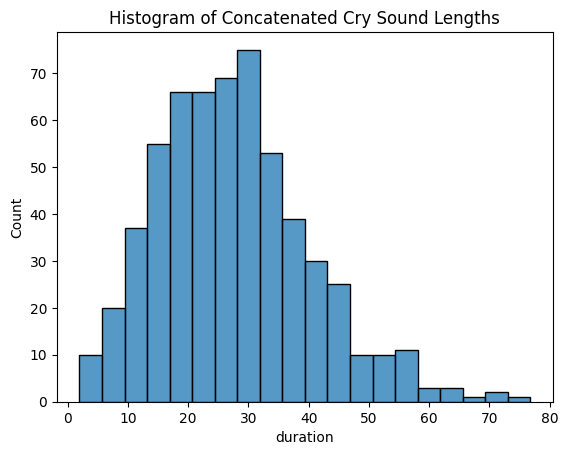

In [6]:
# read the segments
train_metadata["cry"] = train_metadata.apply(
    lambda row: read_audio(f'{dataset_path}/{row["file_name"]}').numpy(), axis=1
)
# concatenate all segments for each (baby_id, period) group
manifest_df = pd.DataFrame(
    train_metadata.groupby(["baby_id"])["cry"].agg(lambda x: np.concatenate(x.values)),
    columns=["cry"],
).reset_index()
# all files have 16000 sampling rate
manifest_df["duration"] = manifest_df["cry"].apply(len) / 16000
pathlib.Path(f"{dataset_path}/concatenated_audio_train").mkdir(exist_ok=True)
manifest_df["file_path"] = manifest_df.apply(
    lambda row: f"{dataset_path}/concatenated_audio_train/{row['baby_id']}.wav",
    axis=1,
)
manifest_df.apply(
    lambda row: write_audio(
        filepath=f'{row["file_path"]}', audio=torch.tensor(row["cry"]), samplerate=16000
    ),
    axis=1,
)
manifest_df = manifest_df.drop(columns=["cry"])
display(manifest_df)
ax = sns.histplot(manifest_df, x="duration")
ax.set_title("Histogram of Concatenated Cry Sound Lengths")

### Split into train and val

For training the embedding, the training data is split randomly into train/val.
As the embedding is trained using a triplet-loss approach, it is no necessary to consider just babies with both period as in the baseline apporach.

In [7]:
def split_by_period(row):
    if random.random() < 0.85:
        return "train"
    else:
        return "val"


manifest_df["split"] = manifest_df.apply(
    lambda row: split_by_period(row), axis=1
)

# each instance will be identified with a unique id
manifest_df["id"] = manifest_df["baby_id"]
display(manifest_df)
display(
    manifest_df["split"]
    .value_counts()
    .rename("use_babies_with_both_recordings_and_split_by_period")
)

,baby_id,duration,file_path,split,id
0,0006,30.170500,data/concatenated_audio_train/0006.wav,train,0006
1,0007,35.722313,data/concatenated_audio_train/0007.wav,train,0007
2,0008,55.656375,data/concatenated_audio_train/0008.wav,train,0008
3,0015,28.328750,data/concatenated_audio_train/0015.wav,train,0015
4,0018,15.252750,data/concatenated_audio_train/0018.wav,val,0018
...,...,...,...,...,...
581,1073,10.405563,data/concatenated_audio_train/1073.wav,train,1073
582,1074,19.724250,data/concatenated_audio_train/1074.wav,train,1074
583,1076,54.328250,data/concatenated_audio_train/1076.wav,val,1076
584,1078,22.190687,data/concatenated_audio_train/1078.wav,train,1078


train    496
val       90
Name: use_babies_with_both_recordings_and_split_by_period, dtype: int64

### Define the dataloader

A torch dataloader is defined with a custom batch_sampler. For each iteration, a batch of indices is extracted, which is sampled with replacement, ensuring that the batch contains a number of audios related to the same baby (positive samples in the triplet loss).



In [8]:
def create_cut_length_interval(row, cut_length_interval):
    """cut_length_interval is a tuple indicating the range of lengths we want our chunks to be.
    this function computes the valid range of chunk lengths for each audio file
    """
    # the lengths are in seconds, convert them to frames
    cut_length_interval = [round(length * 16000) for length in cut_length_interval]
    cry_length = round(row["duration"] * 16000)
    # make the interval valid for the specific sound file
    min_cut_length, max_cut_length = cut_length_interval
    # if min_cut_length is greater than length of cry, don't cut
    if min_cut_length >= cry_length:
        cut_length_interval = (cry_length, cry_length)
    # if max_cut_length is greater than length of cry, take a cut of length between min_cut_length and full length of cry
    elif max_cut_length >= cry_length:
        cut_length_interval = (min_cut_length, cry_length)
    return cut_length_interval


cut_length_interval = (3, 5)
manifest_df["cut_length_interval_in_frames"] = manifest_df.apply(
    lambda row: create_cut_length_interval(row, cut_length_interval=cut_length_interval), axis=1
)


# for reading the train split, we add chunking
def audio_pipeline(file_path, cut_length_interval_in_frames):
    """Load the signal, and pass it and its length to the corruption class.
    This is done on the CPU in the `collate_fn`."""
    sig = sb.dataio.dataio.read_audio(file_path)
    if cut_length_interval_in_frames is not None:
        cut_length = random.randint(*cut_length_interval_in_frames)
        # pick the start index of the cut
        left_index = random.randint(0, len(sig) - cut_length)
        # cut the signal
        sig = sig[left_index : left_index + cut_length]
    return sig


class AudioDataset(Dataset):
    def __init__(self, dataframe, split = 'train'):
        self.dataframe = dataframe[dataframe.split==split] # Filter dataframe based on split
        ids = self.dataframe.id
        unique_ids = list(set(ids)) # Get unique IDs
        self.id_map = {id: i for i, id in enumerate(unique_ids)} # Create a mapping of IDs to indices

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        # audio_pipeline read the audio file and returns a random crop
        audio_item = audio_pipeline(self.dataframe.iloc[index]['file_path'], self.dataframe.iloc[index]['cut_length_interval_in_frames'] )
        # Get the label corresponding to the ID from the id_map
        label = self.id_map[self.dataframe.iloc[index]['id']]
        return audio_item, label

    def shuffle_dataframe(self):
        # Shuffle the dataframe and update the ID mapping
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)
        self.ids = self.dataframe.id
        unique_ids = list(set(self.ids))
        self.id_map = {id: i for i, id in enumerate(unique_ids)}

def collate_fn(batch):
    # Unpack the batch into waveforms and labels
    waveforms, labels = zip(*batch)
    waveforms = [waveform.squeeze() for waveform in waveforms]  # Squeeze waveforms
    waveforms_padded = torch.nn.utils.rnn.pad_sequence(waveforms, batch_first=True) # Pad waveforms
    waveforms_lens = [waveform.shape[-1]/waveforms_padded[0].shape[-1] for waveform in waveforms] # Compute waveform lengths
    return waveforms_padded, waveforms_lens, labels

class Sampler():
    # custom sampler that used to generate batches of random indices for data shuffling and batch sampling in the DataLoader.
    def __init__(self, batch_size, data_len):
        self.batch_size = batch_size
        self.data_len = data_len//batch_size
    def __iter__(self):
      # Generate random indices for the batch.
      # Generates random indices for each batch within the range determined by the current batch index i
      # Each batch can contain multiple occurrences of the same baby_id, these cases are considered 'positive' in the triplet loss.
        batch_idxs = []
        for i in range(self.data_len):
          rnd_indeces = list(random.choices(range(i*(self.batch_size), (i+1)*self.batch_size), k=self.batch_size))
          batch_idxs.append(rnd_indeces)
        return iter(batch_idxs)

# Create the AudioDataset objects
dataset = AudioDataset(manifest_df)
dataset_val = AudioDataset(manifest_df, split = 'val')

dataloader_val =DataLoader(dataset_val,  batch_sampler=Sampler(batch_size = 16, data_len = dataset_val.__len__()), collate_fn=collate_fn)
dataloader = DataLoader(dataset,  batch_sampler=Sampler(batch_size = 16, data_len = dataset.__len__()), collate_fn=collate_fn)


### Load the pre-trained model
Load the  ```speechbrain/spkrec-ecapa-voxceleb``` from the speechbrain library and set all the parameters in the embedding_model as trainable.



In [9]:
!rm -r experiments
!rm -r spkrec-ecapa-voxceleb
!mkdir experiments

In [11]:
from speechbrain.pretrained import EncoderClassifier, SpeakerRecognition
encoder = SpeakerRecognition.from_hparams(
   source="speechbrain/spkrec-ecapa-voxceleb",
   savedir="spkrec-ecapa-voxceleb",
   run_opts={"device": "cuda"},  # comment out if no GPU available
)

for child_idx, child in enumerate(encoder.mods.embedding_model.children()):
    for param in child.parameters():
        param.requires_grad = True
count_total_params = sum(p.numel() for p in encoder.mods.embedding_model.parameters() if p.requires_grad == True)
print(f"Trainable parameters: {count_total_params}")

Trainable parameters: 20767552


### Fine-tune the embedding network using triplet-loss
Herein, a simple training loop is provided to train the embedding using batch_hard_triplet_loss. For each iteration, the hardest positive and negative pairs are selected from the batch to evaluate the loss.

In [ ]:


device = 'cuda'
# Define Adam optimizer
optimizer = torch.optim.Adam(encoder.mods.embedding_model.parameters(), lr=0.001)
num_epochs = 300
# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)



best_validation_loss = float('inf')
best_model_weights = None
model_saved = {}  # Dictionary to store saved models
margin_triplet = 1 # Margin for triplet loss

# Training loop
for epoch in range(num_epochs):

    total_loss = 0.0
    dataloader.dataset.shuffle_dataframe() # Shuffle the dataset before each epoch

    # Iterate over batches in the dataloader
    for wavs, lens, batch_labels in tqdm(dataloader):

        optimizer.zero_grad()
        wavs = wavs.to(device)
        lens = torch.Tensor(lens).to(device)
        batch_labels = torch.Tensor(batch_labels).to(device)


        feats = encoder.mods.compute_features(wavs) # Compute features using the encoder
        feats = encoder.mods.mean_var_norm(feats, lens)  # Perform mean-variance normalization on the features

        embeddings = encoder.mods.embedding_model(feats) # Obtain embeddings from the embedding model
        embeddings = torch.nn.functional.normalize(embeddings, p=2.0, dim = -1)  # Normalize embeddings
        embeddings = embeddings.squeeze() # Remove extra dimensions

        loss = batch_hard_triplet_loss(batch_labels, embeddings, margin=margin_triplet) # Compute triplet loss
        total_loss += loss.item() * wavs.size(0) # Accumulate the loss

        loss.backward()

        optimizer.step()

    epoch_loss = total_loss / len(dataset) # Calculate average epoch loss


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

    val_loss = 0.0
    # Iterate over batches in the validation dataloader
    for wavs, lens, batch_labels in tqdm(dataloader_val):

        wavs = wavs.to(device)
        lens = torch.Tensor(lens).to(device)
        batch_labels = torch.Tensor(batch_labels).to(device)

        feats = encoder.mods.compute_features(wavs)
        feats = encoder.mods.mean_var_norm(feats, lens)


        embeddings = encoder.mods.embedding_model(feats)
        embeddings = torch.nn.functional.normalize(embeddings, p=2.0, dim = -1)
        embeddings = embeddings.squeeze()

        loss = batch_hard_triplet_loss(batch_labels, embeddings, margin=margin_triplet) # Calculate average validation loss
        val_loss += loss.item() * wavs.size(0)


    epoch_loss_val = val_loss / len(dataset_val)

    # Save the model if it performs better than previously saved models
    if len(model_saved.keys()) < 5 or any(epoch_loss_val < v for v in model_saved.values()):
        print('Saving model..')
        if len(model_saved.keys()) >= 5:
          chiave_max_valore = max(model_saved, key=model_saved.get)
          del model_saved[chiave_max_valore]
        model_saved[f'checkpoint_epoch_{epoch+1}_valloss_{epoch_loss_val}.ckpt'] = epoch_loss_val
        best_model_weights = copy.deepcopy(encoder.mods.embedding_model.state_dict())
        torch.save(best_model_weights, f"experiments/checkpoint_epoch_{epoch+1}_valloss_{epoch_loss_val}.ckpt")


    scheduler.step(epoch_loss_val) # Adjust learning rate based on validation loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {epoch_loss_val}")



In [ ]:
# evaluate the best models
model_saved

### Evaluate Performance on Dev-Set
You can now use embedding_model.ckpt from this recipe and use it in evaluate.ipynb to verify pairs of cries and submit your results!

In [35]:
from speechbrain.pretrained import EncoderClassifier, SpeakerRecognition
from speechbrain.utils.metric_stats import EER

In [36]:
# read metadata
metadata = pd.read_csv(
    f"{dataset_path}/metadata.csv", dtype={"baby_id": str, "chronological_index": str}
)
dev_metadata = metadata.loc[metadata["split"] == "dev"].copy()
# read sample submission
sample_submission = pd.read_csv(
    f"{dataset_path}/sample_submission.csv"
)  # scores are unfiorm random
# read verification pairs
dev_pairs = pd.read_csv(
    f"{dataset_path}/dev_pairs.csv", dtype={"baby_id_B": str, "baby_id_D": str}
)
test_pairs = pd.read_csv(f"{dataset_path}/test_pairs.csv")

display(
    metadata.head()
    .style.set_caption("metadata")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(
    dev_pairs.head()
    .style.set_caption("dev_pairs")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(
    test_pairs.head()
    .style.set_caption("test_pairs")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(
    sample_submission.head()
    .style.set_caption("sample_submission")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)

,baby_id,period,duration,split,chronological_index,file_name,file_id
0,0694,B,1.320000,dev,000,audio/dev/0694/B/0694_B_000.wav,0694_B_000
1,0694,B,0.940000,dev,001,audio/dev/0694/B/0694_B_001.wav,0694_B_001
2,0694,B,0.880000,dev,002,audio/dev/0694/B/0694_B_002.wav,0694_B_002
3,0694,B,1.130000,dev,003,audio/dev/0694/B/0694_B_003.wav,0694_B_003
4,0694,B,1.180000,dev,004,audio/dev/0694/B/0694_B_004.wav,0694_B_004


,baby_id_B,baby_id_D,id,label
0,0133,0611,0133B_0611D,0
1,0593,0584,0593B_0584D,0
2,0094,0292,0094B_0292D,0
3,0563,0094,0563B_0094D,0
4,0122,0694,0122B_0694D,0


,baby_id_B,baby_id_D,id
0,anonymous027,anonymous212,anonymous027B_anonymous212D
1,anonymous035,anonymous225,anonymous035B_anonymous225D
2,anonymous029,anonymous288,anonymous029B_anonymous288D
3,anonymous001,anonymous204,anonymous001B_anonymous204D
4,anonymous075,anonymous244,anonymous075B_anonymous244D


,id,score
0,anonymous027B_anonymous212D,0.548814
1,anonymous035B_anonymous225D,0.715189
2,anonymous029B_anonymous288D,0.602763
3,anonymous001B_anonymous204D,0.544883
4,anonymous075B_anonymous244D,0.423655


In [37]:
# Copy one of the best model in the spkrec-ecapa-voxceleb folder
!rm ./spkrec-ecapa-voxceleb/embedding_model.ckpt
# Please, change the checkpoint with one from model_saved
!cp ./experiments/checkpoint_epoch_126_valloss_0.39332668280895844.ckpt ./experiments/embedding_model.ckpt
!mv ./experiments/embedding_model.ckpt ./spkrec-ecapa-voxceleb/embedding_model.ckpt

In [38]:
# Initialize a SpeackerRecognition object with fine-tuned model
encoder = SpeakerRecognition.from_hparams(
   source="speechbrain/spkrec-ecapa-voxceleb",
   savedir="spkrec-ecapa-voxceleb",
   run_opts={"device": "cuda"},  # comment out if no GPU available
)

In [39]:

# read the segments
dev_metadata["cry"] = dev_metadata.apply(
    lambda row: read_audio(f'{dataset_path}/{row["file_name"]}').numpy(), axis=1
)
# concatenate all segments for each (baby_id, period) group
cry_dict = pd.DataFrame(
    dev_metadata.groupby(["baby_id", "period"])["cry"].agg(lambda x: np.concatenate(x.values)),
    columns=["cry"],
).to_dict(orient="index")
# encode the concatenated cries
for (baby_id, period), d in tqdm(cry_dict.items()):
    d["cry_encoded"] = encoder.encode_batch(torch.tensor(d["cry"]), normalize=False)

100%|██████████| 80/80 [00:02<00:00, 39.20it/s]


In [ ]:
def compute_cosine_similarity_score(row, cry_dict):
    cos = torch.nn.CosineSimilarity(dim=-1)
    similarity_score = cos(
        cry_dict[(row["baby_id_B"], "B")]["cry_encoded"],
        cry_dict[(row["baby_id_D"], "D")]["cry_encoded"],
    )
    return similarity_score.item()


dev_pairs["score"] = dev_pairs.apply(
    lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict), axis=1
)

dev_pairs

In [ ]:
dev_pairs[dev_pairs.label == 1]

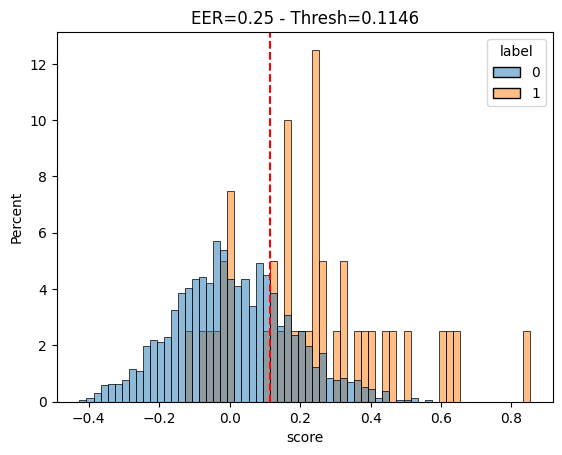

In [42]:
import matplotlib.pyplot as plt
def compute_eer_and_plot_verification_scores(pairs_df):
    """pairs_df must have 'score' and 'label' columns"""
    positive_scores = pairs_df.loc[pairs_df["label"] == 1]["score"].values
    negative_scores = pairs_df.loc[pairs_df["label"] == 0]["score"].values
    eer, threshold = EER(torch.tensor(positive_scores), torch.tensor(negative_scores))
    ax = sns.histplot(pairs_df, x="score", hue="label", stat="percent", binwidth=0.02, common_norm=False)
    ax.set_title(f"EER={round(eer, 4)} - Thresh={round(threshold, 4)}")
    plt.axvline(x=[threshold], color="red", ls="--")
    return eer, threshold


eer, threshold = compute_eer_and_plot_verification_scores(pairs_df=dev_pairs)

### Produce the submission csv

In [ ]:
%%time
test_metadata = metadata.loc[metadata["split"] == "test"].copy()
# read the segments
test_metadata["cry"] = test_metadata.apply(
    lambda row: read_audio(f'{dataset_path}/{row["file_name"]}').numpy(), axis=1
)
# concatenate all segments for each (baby_id, period) group
cry_dict_test = pd.DataFrame(
    test_metadata.groupby(["baby_id", "period"])["cry"].agg(lambda x: np.concatenate(x.values)),
    columns=["cry"],
).to_dict(orient="index")
# encode the concatenated cries
for (baby_id, period), d in tqdm(cry_dict_test.items()):
    d["cry_encoded"] = encoder.encode_batch(torch.tensor(d["cry"]), normalize=False)

# compute cosine similarity between all pairs
test_pairs["score"] = test_pairs.apply(
    lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict_test), axis=1
)
display(test_pairs.head())

In [ ]:

# submission must match the 'sample_submission.csv' format exactly
my_submission = test_pairs[["id", "score"]]
my_submission.to_csv("triplet_loss_submission.csv", index=False)
display(my_submission.head())